8604でオラクルポートを組んでみる．<br>
状態としては，value, growthのみを利用

まず，fetch <br>
分位の作り方はこれではだめ

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pyodbc
import seaborn as sns
from tqdm import tqdm
from sklearn import linear_model

sns.set()
sns.set_style('whitegrid', {'grid.linestyle': '--'})
%matplotlib inline

config_idsqe = 'DSN=IDSQE;UID=ild-vacuser04;PWD=namtk1'
config_labdb901 = 'DSN=LABDB901;UID=labdb901_user01;PWD=labdb901_user01;DATABASE=risk_models'

pd.get_option("display.max_columns")

pd.set_option('display.max_columns', 50)

In [2]:
core = pd.read_csv('./Tpx_core30_19.csv',header=None)
core.columns = ['tse_code','name']
core['nam_cd'] = core.tse_code.apply(lambda x:'JP'+str(x))
core.head()

,tse_code,name,nam_cd
0,2914,日本たばこ産業,JP2914
1,3382,セブン&アイ・ホールディングス,JP3382
2,4063,信越化学工業,JP4063
3,4452,花王,JP4452
4,4502,武田薬品工業,JP4502


In [3]:
core = core.iloc[0:5,:]

In [4]:
sec_codes_JP = list(core.nam_cd)

# 証券コード　⇒　fsym_id　
cnxn = None
sql = "SELECT * FROM risk_models.jpe4_fsym_id_sec_code_map \
         WHERE end_dateymd >= 20140100 AND SEC_CODE in {codes} ".format(codes=tuple(sec_codes_JP))

cnxn = pyodbc.connect(config_labdb901)
sec_fsym = pd.read_sql(sql, cnxn)
cnxn.close()

# fsym_id　⇒　Barra ID　
cnxn = None
sql = "SELECT * FROM risk_models.jpe4_fsym_id_bid_map \
         WHERE end_dateymd >= 20140100 AND fsym_id in {codes} ".format(codes=tuple(sec_fsym.fsym_id.values))

cnxn = pyodbc.connect(config_labdb901)
fsym_bid = pd.read_sql(sql, cnxn)
cnxn.close()

cnxn = None
sql = "SELECT bid, date, drtn FROM risk_models.jpe4_d_prc \
         WHERE 20140100 <= date AND date <= 20190000 AND bid in {codes} ".format(codes=tuple(fsym_bid.bid.values))

cnxn = pyodbc.connect(config_labdb901)
sec_data_daily = pd.read_sql(sql, cnxn)
cnxn.close()

In [5]:
sec_data_daily[sec_data_daily.drtn == -999999998.0]

,bid,date,drtn


In [6]:
sec_data_daily[35525:35526].drtn = np.nan

In [7]:
df = sec_data_daily.pivot(index='date', columns='bid', values='drtn').dropna()
df

bid,JPNBCG1,JPNBFI1,JPNBFM1,JPNCVT1,JPNEOT1
date,,,,,
20140106,-1.3029,-1.5106,-0.2073,0.2392,0.1462
20140107,-1.3201,-0.3067,-0.3115,0.8353,-1.4599
20140108,0.5017,1.2308,0.4167,6.0355,-2.5185
20140109,-2.1631,-0.3040,-0.1037,-0.8929,-3.3435
20140110,-0.3401,0.6098,0.1038,-1.0135,0.4717
20140114,-1.8771,-2.8182,-0.7884,-2.9124,-0.7199
20140115,1.7217,2.8999,1.2129,1.9217,1.5448
20140116,-0.3248,0.8788,0.0826,-0.8278,-0.0310
20140117,0.8062,0.7810,0.4542,-0.5796,-1.0559


In [8]:
df.rolling(20).sum().dropna()
df_oracle = df.rolling(20).sum().dropna()
df_oracle=df_oracle.where(df_oracle < 0, 1).where(df_oracle >= 0, -1)

In [9]:
df_oracle.head()

bid,JPNBCG1,JPNBFI1,JPNBFM1,JPNCVT1,JPNEOT1
date,,,,,
20140203,-1.0,-1.0,-1.0,-1.0,-1.0
20140204,-1.0,-1.0,-1.0,-1.0,-1.0
20140205,-1.0,-1.0,-1.0,-1.0,-1.0
20140206,-1.0,-1.0,-1.0,-1.0,-1.0
20140207,-1.0,-1.0,-1.0,-1.0,1.0


# jpe4_fac

cnxn = None
sql = "SELECT bid, date, fcd, exp FROM risk_models.jpe4_d_exp \
         WHERE 20140100 <= date AND date <= 20190000 AND fcd in (110, 118) AND bid in {codes} ".format(codes=tuple(fsym_bid.bid.values))

cnxn = pyodbc.connect(config_labdb901)
fexp_data_daily = pd.read_sql(sql, cnxn)
cnxn.close()

In [10]:
# jpe4_fac

cnxn = None
sql = "SELECT bid, date, fcd, exp FROM risk_models.jpe4_d_exp \
         WHERE 20140100 <= date AND date <= 20190000 AND fcd in (110, 118)"

cnxn = pyodbc.connect(config_labdb901)
fexp_data_daily = pd.read_sql(sql, cnxn)
cnxn.close()

KeyboardInterrupt: 

In [12]:
# fexp_data_daily.to_csv('barra_valgrw.csv',index=None)
fexp_data_daily = pd.read_csv('barra_valgrw.csv')

In [13]:
fexp_data_daily.shape

(9044674, 4)

In [14]:
fexp_data_daily.head(100000)

,bid,date,fcd,exp
0,JPNAAB1,20140106,110,1.981
1,JPNAAD1,20140106,110,1.232
2,JPNAAF1,20140106,110,-0.380
3,JPNAAH1,20140106,110,-2.066
4,JPNAAJ1,20140106,110,-1.269
5,JPNAAM1,20140106,110,1.394
6,JPNAAN1,20140106,110,1.011
7,JPNAAS1,20140106,110,3.047
8,JPNAAV1,20140106,110,1.850
9,JPNAAX1,20140106,110,-1.136


In [15]:
df_value = fexp_data_daily[fexp_data_daily.fcd==110].reset_index(drop=True).pivot(index='date', columns='bid', values='exp')#.dropna()
df_growth = fexp_data_daily[fexp_data_daily.fcd==118].reset_index(drop=True).pivot(index='date', columns='bid', values='exp')#.dropna()

In [16]:
df_value.head()

bid,JPNAAB1,JPNAAD1,JPNAAF1,JPNAAH1,JPNAAJ1,JPNAAM1,JPNAAN1,JPNAAS1,JPNAAV1,JPNAAX1,JPNAAY1,JPNAAZ1,JPNABC1,JPNABF1,JPNABG1,JPNABH1,JPNABI1,JPNABN1,JPNABR1,JPNABS1,JPNABT1,JPNABX1,JPNABY1,JPNACA1,JPNACB1,...,JPNIOM1,JPNION1,JPNIOO1,JPNIOP1,JPNIOQ1,JPNIOR1,JPNIOS1,JPNIOT1,JPNIOU1,JPNIOV1,JPNIOW1,JPNIOX1,JPNIOY1,JPNIOZ1,JPNIPA1,JPNIPB1,JPNIPC1,JPNIPD1,JPNIPE1,JPNIPF1,JPNIPG1,JPNIPH1,JPNXAA1,JPNXAB1,JPNXAD1
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20140106,1.981,1.232,-0.380,-2.066,-1.269,1.394,1.011,3.047,1.850,-1.136,-0.674,3.545,2.070,3.929,1.071,2.552,1.159,-0.676,2.306,-1.251,1.562,2.376,1.007,0.286,2.203,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.627
20140107,1.980,1.231,-0.380,-2.065,-1.268,1.394,1.010,3.046,1.849,-1.136,-0.673,3.544,2.068,3.928,1.071,2.551,1.159,-0.676,2.305,-1.250,1.561,2.375,1.007,0.286,2.202,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.626
20140108,1.980,1.232,-0.380,-2.065,-1.269,1.395,1.011,3.046,1.849,-1.136,-0.673,3.544,2.068,3.929,1.072,2.551,1.160,-0.675,2.306,-1.250,1.562,2.376,1.008,0.286,2.203,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.626
20140109,1.978,1.230,-0.381,-2.065,-1.269,1.394,1.010,3.044,1.846,-1.136,-0.674,3.541,2.066,3.926,1.070,2.548,1.158,-0.676,2.304,-1.251,1.560,2.374,1.006,0.285,2.201,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.627
20140110,1.978,1.231,-0.381,-2.064,-1.268,1.394,1.010,3.043,1.846,-1.135,-0.673,3.541,2.065,3.925,1.071,2.548,1.158,-0.675,2.304,-1.250,1.560,2.373,1.006,0.285,2.200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.626


In [17]:
df_growth.head()

bid,JPNAAB1,JPNAAD1,JPNAAF1,JPNAAH1,JPNAAJ1,JPNAAM1,JPNAAN1,JPNAAS1,JPNAAV1,JPNAAX1,JPNAAY1,JPNAAZ1,JPNABC1,JPNABF1,JPNABG1,JPNABH1,JPNABI1,JPNABN1,JPNABR1,JPNABS1,JPNABT1,JPNABX1,JPNABY1,JPNACA1,JPNACB1,...,JPNIOM1,JPNION1,JPNIOO1,JPNIOP1,JPNIOQ1,JPNIOR1,JPNIOS1,JPNIOT1,JPNIOU1,JPNIOV1,JPNIOW1,JPNIOX1,JPNIOY1,JPNIOZ1,JPNIPA1,JPNIPB1,JPNIPC1,JPNIPD1,JPNIPE1,JPNIPF1,JPNIPG1,JPNIPH1,JPNXAA1,JPNXAB1,JPNXAD1
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20140106,-0.069,0.423,-1.850,-2.792,0.468,2.079,0.334,0.430,-1.365,-1.176,0.970,-0.150,-0.378,0.015,-0.269,-2.453,-0.047,1.921,-0.333,0.360,1.682,0.122,0.219,-0.508,0.892,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.956
20140107,-0.069,0.423,-1.851,-2.793,0.467,2.080,0.334,0.430,-1.367,-1.176,0.970,-0.151,-0.379,0.014,-0.270,-2.454,-0.048,1.921,-0.333,0.360,1.682,0.121,0.219,-0.508,0.892,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.959
20140108,-0.070,0.422,-1.852,-2.791,0.468,2.078,0.333,0.429,-1.366,-1.177,0.969,-0.152,-0.379,0.013,-0.271,-2.453,-0.049,1.919,-0.334,0.359,1.680,0.120,0.217,-0.509,0.891,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.952
20140109,-0.073,0.420,-1.854,-2.793,0.464,2.076,0.330,0.426,-1.368,-1.179,0.968,-0.154,-0.381,0.011,-0.273,-2.456,-0.050,1.917,-0.336,0.356,1.678,0.118,0.215,-0.511,0.889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.952
20140110,-0.073,0.422,-1.852,-2.790,0.467,2.075,0.331,0.427,-1.366,-1.177,0.968,-0.152,-0.380,0.012,-0.272,-2.452,-0.049,1.917,-0.335,0.357,1.679,0.119,0.217,-0.510,0.889,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.952


In [20]:
np.isnan(np.nan)

True

In [25]:
df_growth_q = df_growth.copy()
df_value_q = df_value.copy()

#for i in tqdm(range(0,df_growth_q.shape[1])):
for i in tqdm(range(0,df_growth_q.shape[0])):
    #print(i)
    df_growth_q.iloc[i,:] = pd.qcut(df_growth.iloc[i,:],5,labels=[0,1,2,3,4])
    df_value_q.iloc[i,:] = pd.qcut(df_value.iloc[i,:],5,labels=[0,1,2,3,4])


100%|██████████| 1225/1225 [00:05<00:00, 204.85it/s]


In [26]:
df_value_q = df_value_q.transpose()[df_value_q.columns.isin(list(fsym_bid.bid.values))].transpose().applymap(lambda x: int(x) if not np.isnan(x) else x)
df_growth_q = df_growth_q.transpose()[df_growth_q.columns.isin(list(fsym_bid.bid.values))].transpose().applymap(lambda x: int(x) if not np.isnan(x) else x)

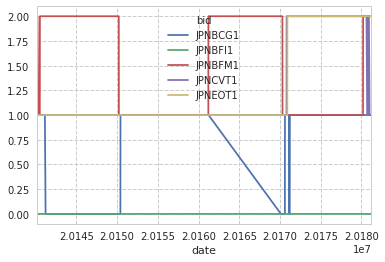

In [27]:
df_value_q.plot()

In [28]:
df_growth_q.head()

bid,JPNBCG1,JPNBFI1,JPNBFM1,JPNCVT1,JPNEOT1
date,,,,,
20140106,1,2,1,1,0
20140107,1,2,1,1,0
20140108,1,2,1,1,0
20140109,1,2,1,1,0
20140110,1,2,1,1,0


In [143]:
df_oracle.to_csv('./data_4toy/oracle.csv')
df_value_q.to_csv('./data_4toy/val_q.csv')
df_growth_q.to_csv('./data_4toy/growth_q.csv')

ここから逆強化学習

In [29]:
import state
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline 

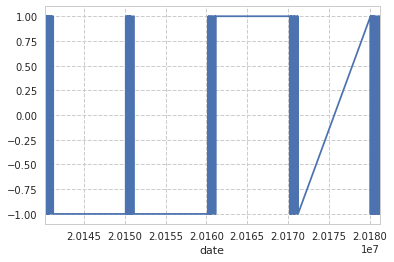

In [30]:
df_oracle.iloc[:,0].plot()

In [31]:
def encoding(oracle, value, growth):
    days = oracle.shape[0]
    num_ind = oracle.shape[1]
    feature = np.zeros((num_ind,5,5))
    for i in range(0,num_ind):
        for j in range(0,days):
            #print(i,j)
            q_val = value.iloc[j,i] - 1
            q_growth = growth.iloc[j,i] - 1
            #print(q_val,q_growth)
            feature[i][q_val][q_growth] += oracle.iloc[j,i]
    return feature/days

In [32]:
feature = encoding(df_oracle,df_value_q,df_growth_q)
feature

array([[[ 0.02570481,  0.02819237,  0.12023217,  0.        ,
          0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.        , -0.00829187,  0.013267  ,  0.        ,
          0.        ]],

       [[ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ],
        [ 0.        ,  0.10033167,  0.20812604,  0.        ,
          0.        ]],

       [[ 0.00165837,  0.04311774,  0.00165837,  0.        ,
          0.        ],
        [-0.0066335 ,  0.039801  ,  0.        ,  0.        ,
          0

In [33]:
import state as st
s = st.State(T = feature)

In [34]:
s.shape()

(5, 5, 5)

In [35]:
s.show()

[[[ 0.02570481  0.02819237  0.12023217  0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.         -0.00829187  0.013267    0.          0.        ]]

 [[ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.10033167  0.20812604  0.          0.        ]]

 [[ 0.00165837  0.04311774  0.00165837  0.          0.        ]
  [-0.0066335   0.039801    0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]]

 [[-0.00912106  0.01741294 -0.0066

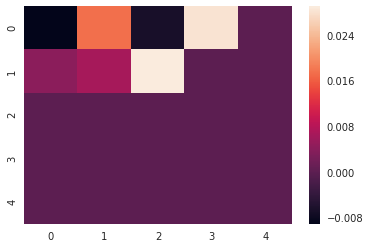

In [66]:
sns.heatmap(s.T[3])

In [67]:
import random
div = 10

l = list(df_oracle.index)
random.seed(0)
random.shuffle(l)
tmp = np.array_split(l,div)
chunk = []
for i in range(0,div):
    chunk.append(list(tmp[i]))
chunk[0][0:3]

[20170726, 20161228, 20160527]

In [68]:
trj = []
for c in chunk:
    tmp = []
    tmp_df = df_oracle[df_oracle.index.isin(c)]
    for i in range(0,tmp_df.shape[0]):
        tmp.append(list(tmp_df.iloc[i,:]))
    trj.append(tmp)
trj[0][0:3]

[[1.0, 1.0, 1.0, -1.0, 1.0],
 [1.0, 1.0, 1.0, 1.0, 1.0],
 [1.0, 1.0, -1.0, 1.0, 1.0]]

書き直せるpolicy

In [69]:
from policy import eps_greedy

state = [[1,1]]
rewards = [[0.5,0.3,-0.2,0]]
for i in range(0,5):
    print(eps_greedy(state,rewards))

state = [[1,1],[1,2]]
rewards = [[0.5,0.3,-0.2,0],[-0.1,0.3, 0,0.5]]
for i in range(0,5):
    print(eps_greedy(state,rewards))

([<Action.BUY: 1>], [{'BUY': 1.0}])
([<Action.BUY: 1>], [{'BUY': 1.0}])
([<Action.BUY: 1>], [{'BUY': 1.0}])
([<Action.BUY: 1>], [{'BUY': 1.0}])
([<Action.BUY: 1>], [{'BUY': 1.0}])
([<Action.SELL: -1>, <Action.SELL: -1>], [{'BUY': 0.5, 'SELL': 0.5}, {'BUY': 0.5, 'SELL': 0.5}])
([<Action.BUY: 1>, <Action.BUY: 1>], [{'BUY': 1.0}, {'BUY': 1.0}])
([<Action.BUY: 1>, <Action.BUY: 1>], [{'BUY': 0.5, 'SELL': 0.5}, {'BUY': 0.5, 'SELL': 0.5}])
([<Action.SELL: -1>, <Action.BUY: 1>], [{'BUY': 0.5, 'SELL': 0.5}, {'BUY': 0.5, 'SELL': 0.5}])
([<Action.BUY: 1>, <Action.BUY: 1>], [{'BUY': 1.0}, {'BUY': 1.0}])


In [70]:
s.show()

[[[ 0.02570481  0.02819237  0.12023217  0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.         -0.00829187  0.013267    0.          0.        ]]

 [[ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.10033167  0.20812604  0.          0.        ]]

 [[ 0.00165837  0.04311774  0.00165837  0.          0.        ]
  [-0.0066335   0.039801    0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]]

 [[-0.00912106  0.01741294 -0.0066

In [71]:
basis = st.State(1,5)
basis.mk_basis()

In [72]:
t_size = len(trj)
n, q, _ = feature.shape
transition_probs = np.zeros((t_size, n, q, q))
initial_state_probs = np.zeros((n,q,q))
#print(t_size,transition_probs,transition_probs.shape,initial_state_probs)
#print(initial_state_probs)

for t, c in zip(trj, chunk):
    val = list(df_value_q[df_value_q.index.isin([c[0]])].head(1).values[0])
    growth = list(df_growth_q[df_growth_q.index.isin([c[0]])].head(1).values[0])
    for i,v,g in zip(range(initial_state_probs.shape[0]),val,growth):
        initial_state_probs[i][v][g] += t[0][i]
        #print(t[0][i],v,g)
    #print('-------------------------')

initial_state_probs /= t_size
transition_probs[0] = initial_state_probs

#print(transition_probs)
print(initial_state_probs)
print('-----------------------------')
print(transition_probs)


[[[ 0.   0.   0.  -0.2  0. ]
  [ 0.   0.  -0.1 -0.3  0. ]
  [ 0.   0.   0.   0.   0. ]
  [ 0.   0.   0.   0.   0. ]
  [ 0.   0.   0.   0.   0. ]]

 [[ 0.   0.  -0.3 -0.3  0. ]
  [ 0.   0.   0.   0.   0. ]
  [ 0.   0.   0.   0.   0. ]
  [ 0.   0.   0.   0.   0. ]
  [ 0.   0.   0.   0.   0. ]]

 [[ 0.   0.   0.   0.   0. ]
  [ 0.   0.  -0.2  0.   0. ]
  [ 0.  -0.3 -0.1  0.   0. ]
  [ 0.   0.   0.   0.   0. ]
  [ 0.   0.   0.   0.   0. ]]

 [[ 0.   0.   0.   0.   0. ]
  [ 0.  -0.1 -0.2 -0.4 -0.2]
  [ 0.   0.  -0.1  0.   0. ]
  [ 0.   0.   0.   0.   0. ]
  [ 0.   0.   0.   0.   0. ]]

 [[ 0.   0.   0.   0.   0. ]
  [ 0.2  0.3  0.   0.   0. ]
  [-0.1  0.   0.   0.   0. ]
  [ 0.   0.   0.   0.   0. ]
  [ 0.   0.   0.   0.   0. ]]]
-----------------------------
[[[[ 0.   0.   0.  -0.2  0. ]
   [ 0.   0.  -0.1 -0.3  0. ]
   [ 0.   0.   0.   0.   0. ]
   [ 0.   0.   0.   0.   0. ]
   [ 0.   0.   0.   0.   0. ]]

  [[ 0.   0.  -0.3 -0.3  0. ]
   [ 0.   0.   0.   0.   0. ]
   [ 0.   0.   0.   0. 

In [144]:
for stk_i in range(0,n):
    for t in range(1, t_size):
        #for prev_s in basis.basis:
        for prev_s in range(0,q*q):
            prev_prob = transition_probs[stk_i][t-1][int(3/q)][3%q]
            # バンデット問題へ変更
            # a = self.planner.act(prev_s)
            # probs = self.env.transit_func(prev_s, a)
            actions, probs = eps_greedy(state,rewards)
            for s in probs[stk_i].values():
                #transition_probs[t][s] += prev_prob * probs[s]
                 transition_probs[stk_i][t][int(3/q)][3%q] += prev_prob * probs[s]

total = np.mean(transition_probs, axis=0)

TypeError: list indices must be integers or slices, not float

In [110]:
print(eps_greedy(state,rewards))

([<Action.BUY: 1>, <Action.BUY: 1>], [{'BUY': 1.0}, {'BUY': 1.0}])


In [116]:
a,b = eps_greedy(state,rewards)

In [117]:
a

[<Action.BUY: 1>, <Action.BUY: 1>]

In [118]:
b

[{'BUY': 1.0}, {'BUY': 1.0}]

In [137]:
for i in b[0].values():
    print(i)

1.0


In [134]:
b[0]#['BUY']

1.0

In [ ]:
states = self.env.states
transition_probs = np.zeros((t_size, len(states)))

initial_state_probs = np.zeros(len(states))
for t in trajectories:
    initial_state_probs[t[0]] += 1
initial_state_probs /= t_size
transition_probs[0] = initial_state_probs

for t in range(1, t_size):
    for prev_s in states:
        prev_prob = transition_probs[t - 1][prev_s]
        a = self.planner.act(prev_s)
        probs = self.env.transit_func(prev_s, a)
        for s in probs:
            transition_probs[t][s] += prev_prob * probs[s]

total = np.mean(transition_probs, axis=0)

In [ ]:
def main():
    irl = MaxEntIRL(env)
    # one-hot vecの基底を作成，縦に積む．
    state_features = np.vstack([self.env.state_to_feature(s)
                               for s in self.env.states])
    theta = np.random.uniform(size=state_features.shape[1])

    # 行動をone-hotのエピソード平均へ 
    # e.g.) trajectories = [[12, 13, 14, 14, 15, 11, 7, 3, 3], [12, 13, 14, 15, 11, 10, 14, 15, 11, 7, 3, 3]]
    teacher_features = self.calculate_expected_feature(trajectories)

    for e in tqdm(range(epoch)):
        # Estimate reward.
        rewards = state_features.dot(theta.T)

        # Optimize policy under estimated reward.
        self.planner.reward_func = lambda s: rewards[s]
        self.planner.plan(gamma=gamma)

        # Estimate feature under policy.
        features = self.expected_features_under_policy(
                            self.planner.policy, trajectories)

        # Update to close to teacher.
        update = teacher_features - features.dot(state_features)
        theta += learning_rate * update

    estimated = state_features.dot(theta.T)
    estimated = estimated.reshape(self.env.shape)
    rewards = irl.estimate(trajectories, epoch=100)
    
    print(rewards)
    env.plot_on_grid(rewards)

In [ ]:
teacher_feature = pd.DataFrame((df_oracle > 0).sum()/df_oracle.shape[0],columns=['p'])
teacher_feature['n'] = 1 - teacher_feature.p
teacher_feature